In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn.metrics import mean_squared_error

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:

def score_for_res(pred, trueval) :
    u2 = (pred-trueval)**2
    v2 = (trueval-trueval.mean())**2
    
    return 1-(u2.sum()/v2.sum())




In [3]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv', index_col='date', parse_dates=['date'])
network.head()

network2 = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv')
network2.head()

network.describe()

,target
count,172800.000000
mean,428.157720
std,39.253344
min,241.308025
25%,402.000000
50%,426.000000
75%,452.000000
max,677.615002


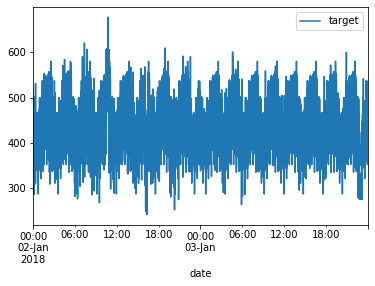

In [4]:
network.plot()

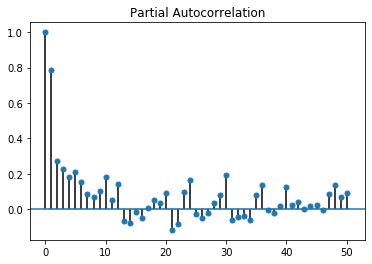

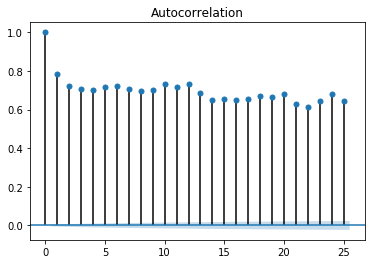

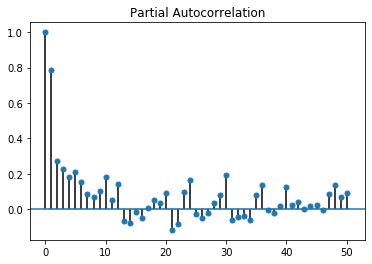

In [5]:
plot_acf(network, lags=25);
plot_pacf(network, lags=50)

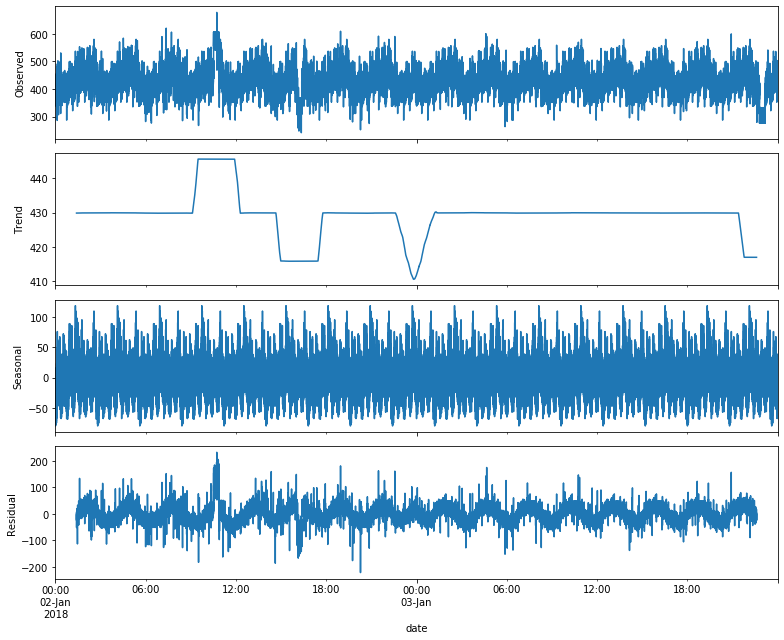

In [6]:
rcParams['figure.figsize'] = 11,9
decomposed_network = sm.tsa.seasonal_decompose(network, freq=10080)
figure = decomposed_network.plot()
plt.show()

,target
count,172799.000000
mean,0.000370
std,25.784710
min,-192.765426
25%,-17.000000
50%,0.000000
75%,17.000000
max,233.624171


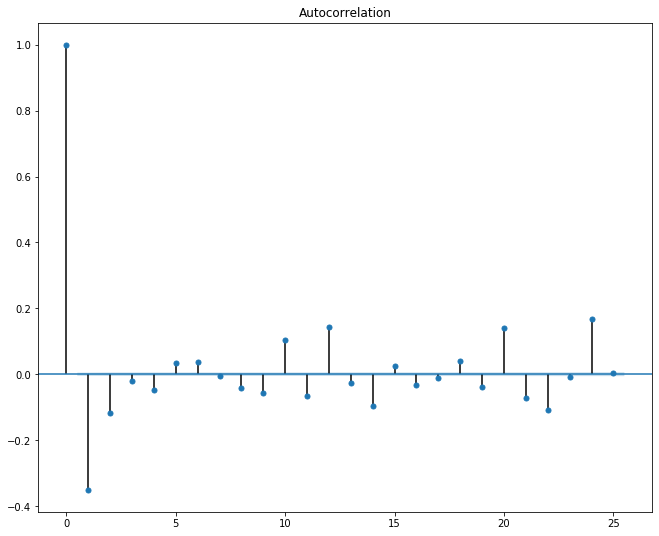

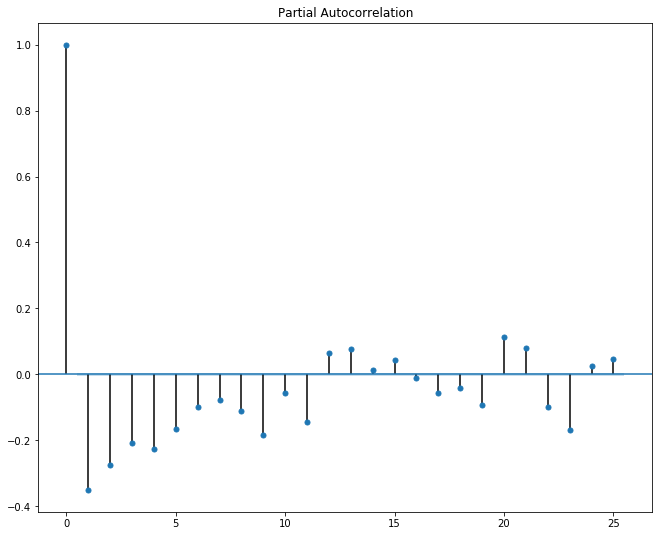

In [7]:
netdiff = network.diff()[1:]



plot_acf(netdiff, lags=25)
plot_pacf(netdiff, lags=25)

netdiff.describe()

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:               172799
Model:                 ARIMA(0, 1, 2)   Log Likelihood             -773858.071
Method:                       css-mle   S.D. of innovations             21.315
Date:                Sun, 08 Sep 2019   AIC                        1547724.142
Time:                        16:59:06   BIC                        1547764.381
Sample:                    01-02-2018   HQIC                       1547736.061
                         - 01-03-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0002      0.007      0.032      0.975      -0.013       0.014
ma.L1.D.target    -0.6539      0.002   -280.756      0.000      -0.658      -0.649
ma.L2.D.target    -0.2102      0.002

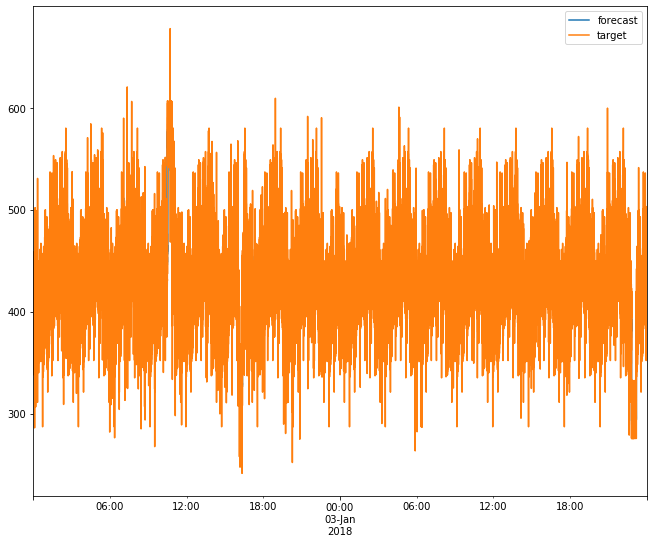

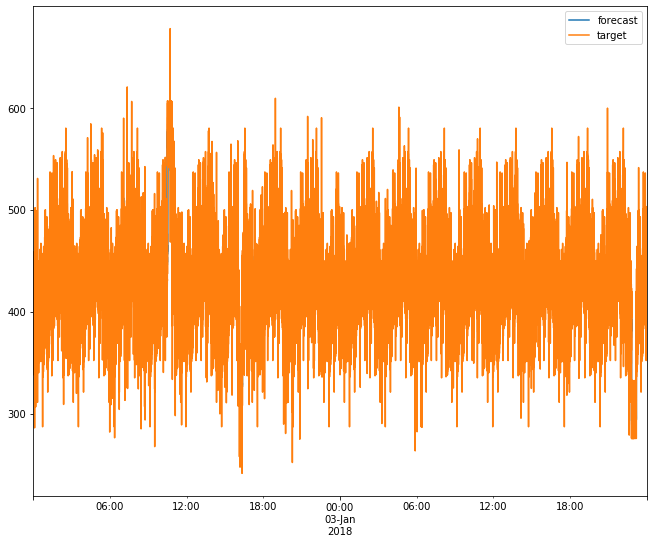

In [8]:
arima = ARIMA(network, order=(0, 1, 2))
result = arima.fit()
print(result.summary())

result.plot_predict()



In [9]:
pred_arima = result.predict()

u2 = (pred_arima)**2
v2 = (network.target[1:]-network.target[1:].mean())**2
1-(u2.sum()/v2.sum())

0.8605896498760296

mondrian forest 과거 3개값

In [10]:
idx = network.index

tmp = network.shift(1)
tmp2 = network.shift(2)
tmp3 = network.shift(3)
tmp4 = network.shift(4)

network_prev = network.copy()
network_prev['prev1'] = tmp['target']
network_prev['prev2'] = tmp2['target']
network_prev['prev3'] = tmp3['target']

network_prev = network_prev[4:]
network_prev.head()

trainIdx = 10000
iterRange = 10001


In [11]:
def partial_train(mtr, X_test, y_test, X_prev, y_prev):
    mtr.partial_fit(X_prev, y_prev)
    X_prev = X_test
    y_prev = y_test
    
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std


In [12]:
X = network_prev[['prev1', 'prev2', 'prev3']]
y = network_prev['target']

X_train = X[:trainIdx]
y_train = y[:trainIdx]

X_test = X[trainIdx:trainIdx+1]
y_test = y[trainIdx:trainIdx+1]

print(X_test)


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)
prediction3 = np.array([y_pred])
stdeviation3 = np.array([y_std])




                     prev1  prev2  prev3
date                                    
2018-01-02 02:46:44  415.0  426.0  433.0


In [13]:
for next in range(trainIdx+1, trainIdx+iterRange):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    y_pred, y_std = partial_train(mtr, X_test, y_test, X_prev, y_prev)
    prediction3 = np.append(prediction3, [y_pred])
    stdeviation3 = np.append(stdeviation3, [y_std])
    
    #print('iter : %d , pred : %f, std: %f, y: %f'%(next, y_pred, y_std, y_test))
    


2018-01-02 00:00:00
date
2018-01-02 00:00:04    361.0
Name: target, dtype: float64


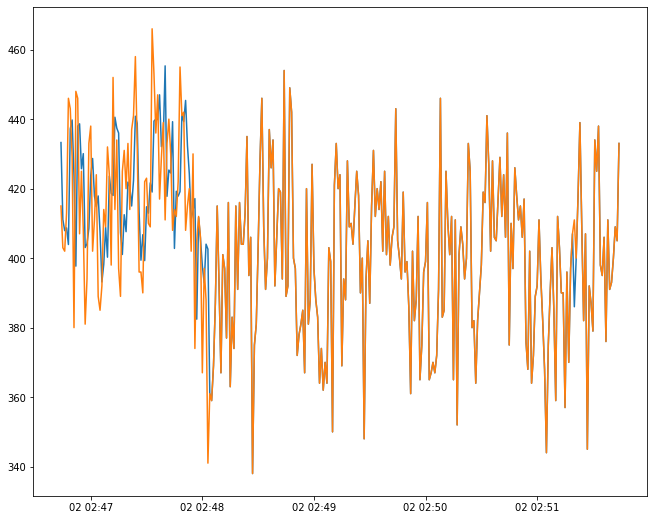

In [14]:
plt.plot(idx[10000+4:10301+4], prediction3[0:301])
plt.plot(y[10000:10301])

print(idx[0])
print(y[0:1])

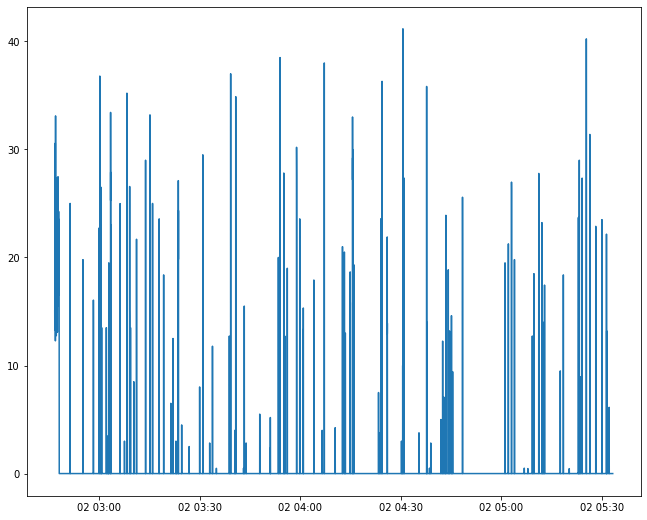

In [15]:
plt.plot(idx[trainIdx:trainIdx+iterRange], stdeviation3[:iterRange])

In [16]:
score_for_res(prediction3, y[trainIdx:trainIdx+iterRange])

0.9657442991569034

In [17]:

X.iloc[0]
X.iloc[1]
X.iloc[0].eq(X.iloc[1])

prev1    False
prev2    False
prev3    False
dtype: bool

In [18]:
'''
#check the same prev values because the std is 0 since 10080
#The same value exists every 10080 cycles.


for i in range(1 , 20001) :
    if (X.iloc[i].eq(X.iloc[i+10080]).all()):
        print("%d same"%(i))
        
    else :
        print("%d not same!!!!"%(i))
'''

'\n#check the same prev values because the std is 0 since 10080\n#The same value exists every 10080 cycles.\n\n\nfor i in range(1 , 20001) :\n    if (X.iloc[i].eq(X.iloc[i+10080]).all()):\n        print("%d same"%(i))\n        \n    else :\n        print("%d not same!!!!"%(i))\n'

과거 1개 값 보기

In [19]:
network_prev1 = network.copy()
network_prev1['prev'] = tmp['target']

network_prev1 = network_prev1[1:]

network_prev1[0:5]


,target,prev
date,,
2018-01-02 00:00:01,397.0,367.0
2018-01-02 00:00:02,388.0,397.0
2018-01-02 00:00:03,341.0,388.0
2018-01-02 00:00:04,361.0,341.0
2018-01-02 00:00:05,359.0,361.0


In [20]:
X = network_prev1['prev'].values.reshape(-1, 1)
y = network_prev1['target']

X_train = X[:trainIdx]
y_train = y[:trainIdx]

X_test = X[trainIdx:trainIdx+1]
y_test = y[trainIdx:trainIdx+1]


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)

prediction1 = np.array([y_pred])
stdeviation1 = np.array([y_std])


for next in range(trainIdx+1, trainIdx+iterRange):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    y_pred, y_std = partial_train(mtr, X_test, y_test, X_prev, y_prev)
    
    prediction1 = np.append(prediction1, [y_pred])
    stdeviation1 = np.append(stdeviation1, [y_std])
    

2018-01-02 00:00:00
date
2018-01-02 00:00:01    397.0
Name: target, dtype: float64


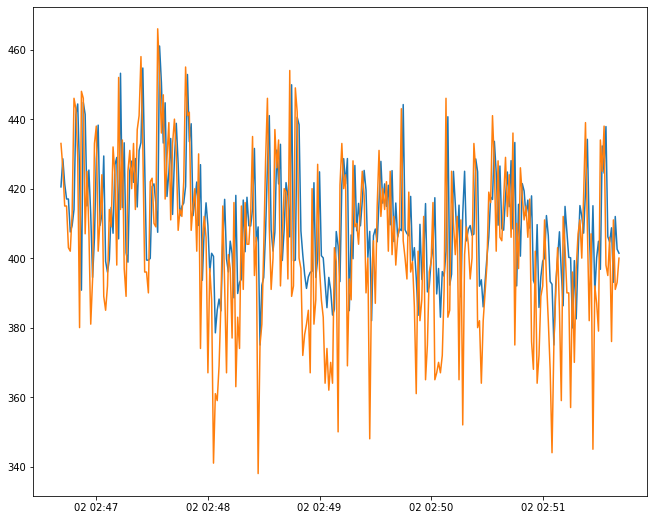

In [21]:
plt.plot(idx[trainIdx+1:trainIdx+301+1], prediction1[:301])
plt.plot(y[trainIdx:trainIdx+301])

print(idx[0])
print(y[0:1])

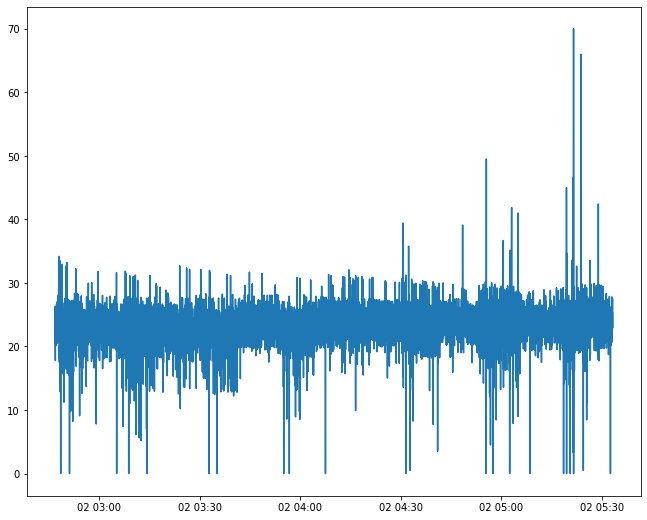

In [22]:
plt.plot(idx[trainIdx:trainIdx+iterRange], stdeviation1[:iterRange])

In [23]:
score_for_res(prediction1, y[trainIdx:trainIdx+iterRange])

mtr.score(prediction1.reshape(-1, 1), y[trainIdx:trainIdx+iterRange])

0.5060797276845697

과거 2개 값 보기

In [24]:
network_prev2 = network.copy()
network_prev2['prev1'] = tmp['target']
network_prev2['prev2'] = tmp2['target']
network_prev2 = network_prev2[2:]

network_prev2[0:5]

,target,prev1,prev2
date,,,
2018-01-02 00:00:02,388.0,397.0,367.0
2018-01-02 00:00:03,341.0,388.0,397.0
2018-01-02 00:00:04,361.0,341.0,388.0
2018-01-02 00:00:05,359.0,361.0,341.0
2018-01-02 00:00:06,369.0,359.0,361.0


In [25]:
X = network_prev2[['prev1', 'prev2']]
y = network_prev2['target']

X_train = X[:trainIdx]
y_train = y[:trainIdx]

X_test = X[trainIdx:trainIdx+1]
y_test = y[trainIdx:trainIdx+1]


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)

prediction2 = np.array([y_pred])
stdeviation2 = np.array([y_std])


for next in range(trainIdx+1, trainIdx+iterRange):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    y_pred, y_std = partial_train(mtr, X_test, y_test, X_prev, y_prev)
    
    prediction2 = np.append(prediction2, [y_pred])
    stdeviation2 = np.append(stdeviation2, [y_std])
    
    #print('iter : %d , pred : %f, std: %f, y: %f'%(next, y_pred, y_std, y_test))

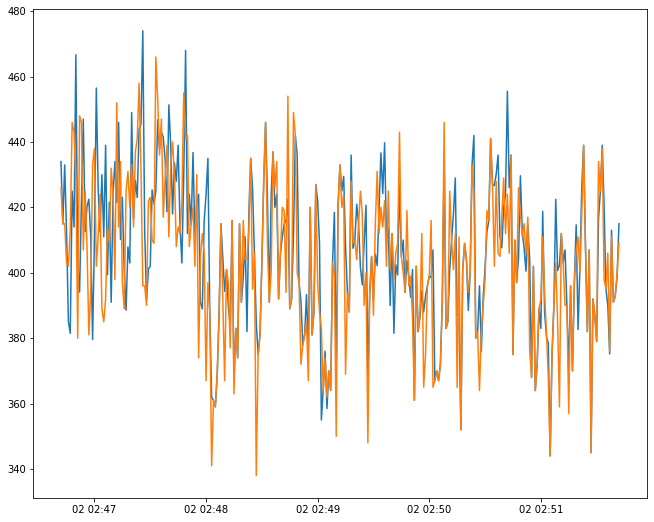

In [28]:
plt.plot(idx[trainIdx+2:trainIdx+301+2], prediction2[0:301])
plt.plot(y[trainIdx:trainIdx+301])



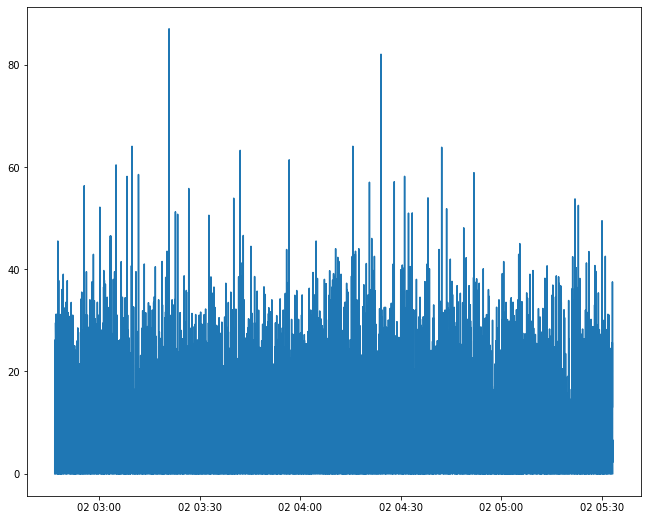

In [29]:
plt.plot(idx[trainIdx:trainIdx+iterRange], stdeviation2[:iterRange])


In [30]:
score_for_res(prediction2, y[trainIdx:trainIdx+iterRange])


0.7886375867944851

#### 4개

In [31]:
network_prev4 = network.copy()
network_prev4['prev1'] = tmp['target']
network_prev4['prev2'] = tmp2['target']
network_prev4['prev3'] = tmp3['target']
network_prev4['prev4'] = tmp4['target']

network_prev4 = network_prev4[5:]


In [32]:
X = network_prev4[['prev1', 'prev2', 'prev3', 'prev4']]
y = network_prev4['target']

X_train = X[:trainIdx]
y_train = y[:trainIdx]

X_test = X[trainIdx:trainIdx+1]
y_test = y[trainIdx:trainIdx+1]

print(X_test)


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)
prediction4 = np.array([y_pred])
stdeviation4 = np.array([y_std])

                     prev1  prev2  prev3  prev4
date                                           
2018-01-02 02:46:45  415.0  415.0  426.0  433.0


In [33]:
for next in range(trainIdx+1, trainIdx+iterRange):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    y_pred, y_std = partial_train(mtr, X_test, y_test, X_prev, y_prev)
    prediction4 = np.append(prediction4, [y_pred])
    stdeviation4 = np.append(stdeviation4, [y_std])
    
    #print('iter : %d , pred : %f, std: %f, y: %f'%(next, y_pred, y_std, y_test))
    

2018-01-02 00:00:05
date
2018-01-02 00:00:05    359.0
Name: target, dtype: float64


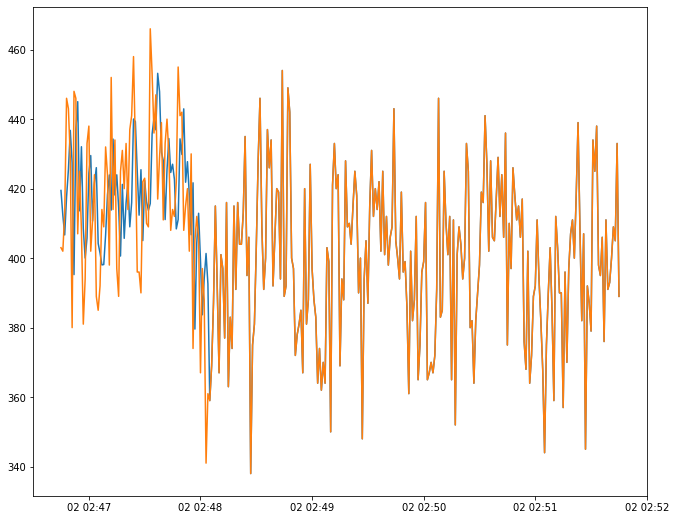

In [34]:
plt.plot(idx[10005:10306], prediction4[0:301])

plt.plot(y[10000:10301])


print(idx[5])
print(y[0:1])


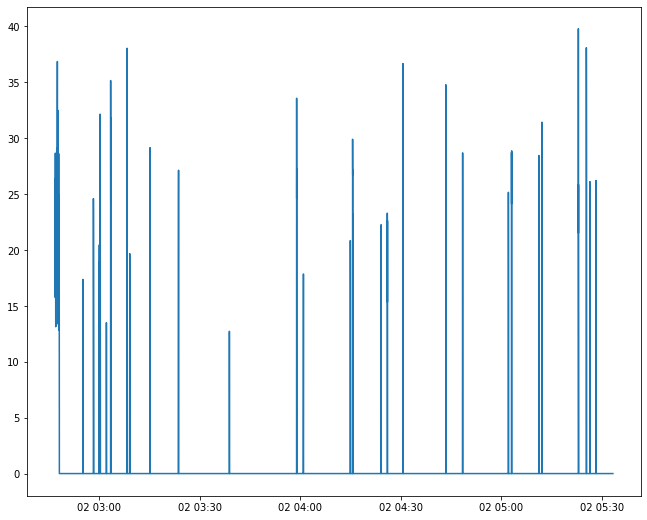

In [35]:
plt.plot(idx[trainIdx:trainIdx+iterRange], stdeviation4[:iterRange])

In [36]:
score_for_res(prediction4, y[trainIdx:trainIdx+iterRange])



0.9685456531548375